In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


import jax


from src.simulate_trace import MakePulse, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse


In [2]:
pulse_maker = MakePulse(N=128*10, Delta_f=2)

central_f = np.array([0.35])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.array([0.5, 0, 0, 5000]))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.05]))
pulse = (amp, phase)

# central_f = np.array([0.3, 0.3])
# phase1 = PolynomialPhase(central_frequency = central_f[0], coefficients = np.array([0.5, 0, -100]))
# phase2 = PolynomialPhase(central_frequency = central_f[1], coefficients = np.array([0.5, 0, 100]))
# pulse = MultiPulse(delay=np.array([100]), duration=np.array([10,10]), central_frequency=central_f, amplitude=np.array([1,1]), phase=[phase, phase])
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse(pulse)


central_f = np.array([0.51])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.zeros(3))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.1]))
time_gate, pulse_t_gate, frequency_gate, pulse_f_gate = pulse_maker.generate_pulse((amp, phase))

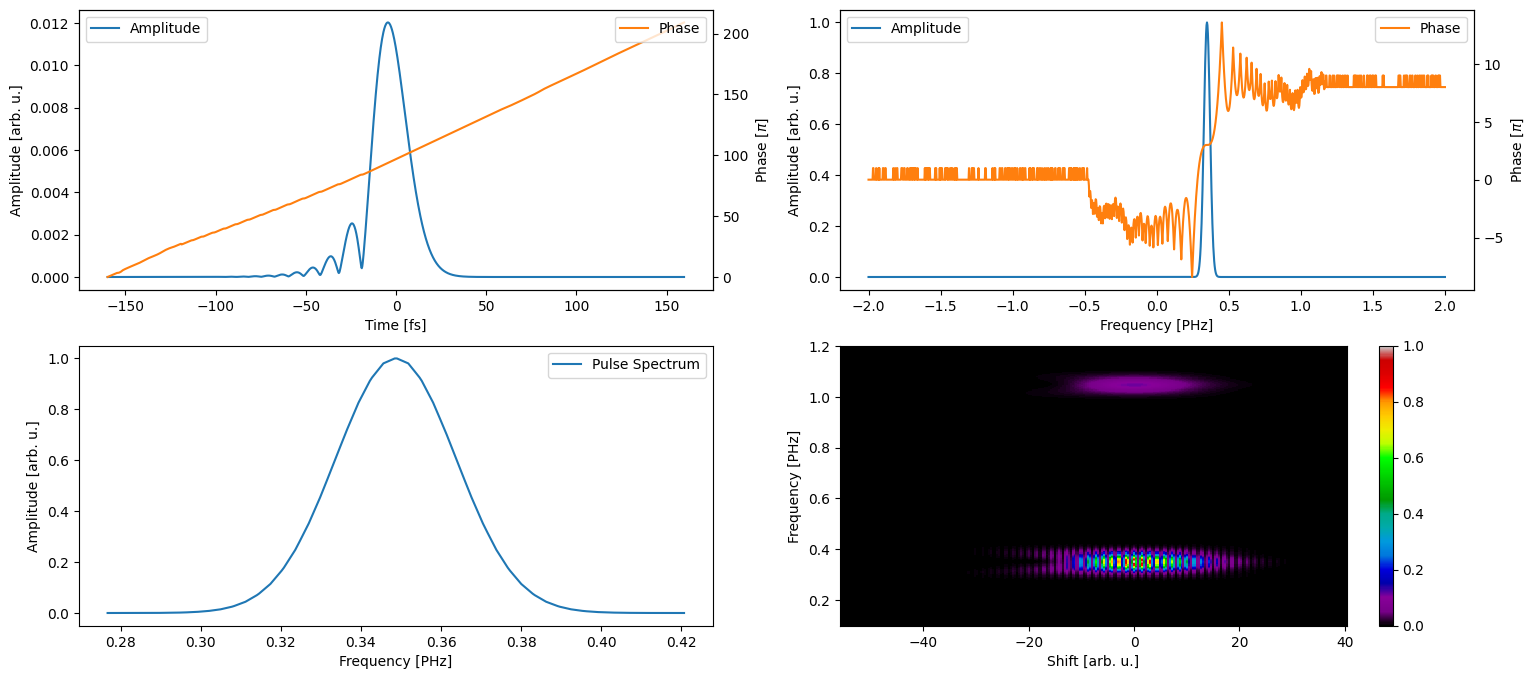

In [3]:
time, frequency, trace, spectra=pulse_maker.generate_frog(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, nonlinear_method="thg", 
                                                          scale_time_range=1, N=128*2, cross_correlation=False, 
                                                          gate=(frequency_gate, pulse_f_gate),
                                                          interpolate_fft_conform=False, 
                                                          cut_off_val=1e-4, ifrog=False, real_fields=True, frequency_range=(0.1,1.2))

#trace = apply_noise(trace, scale_val=(0.05, 0.05), additive_noise=True, multiplicative_noise=True)

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


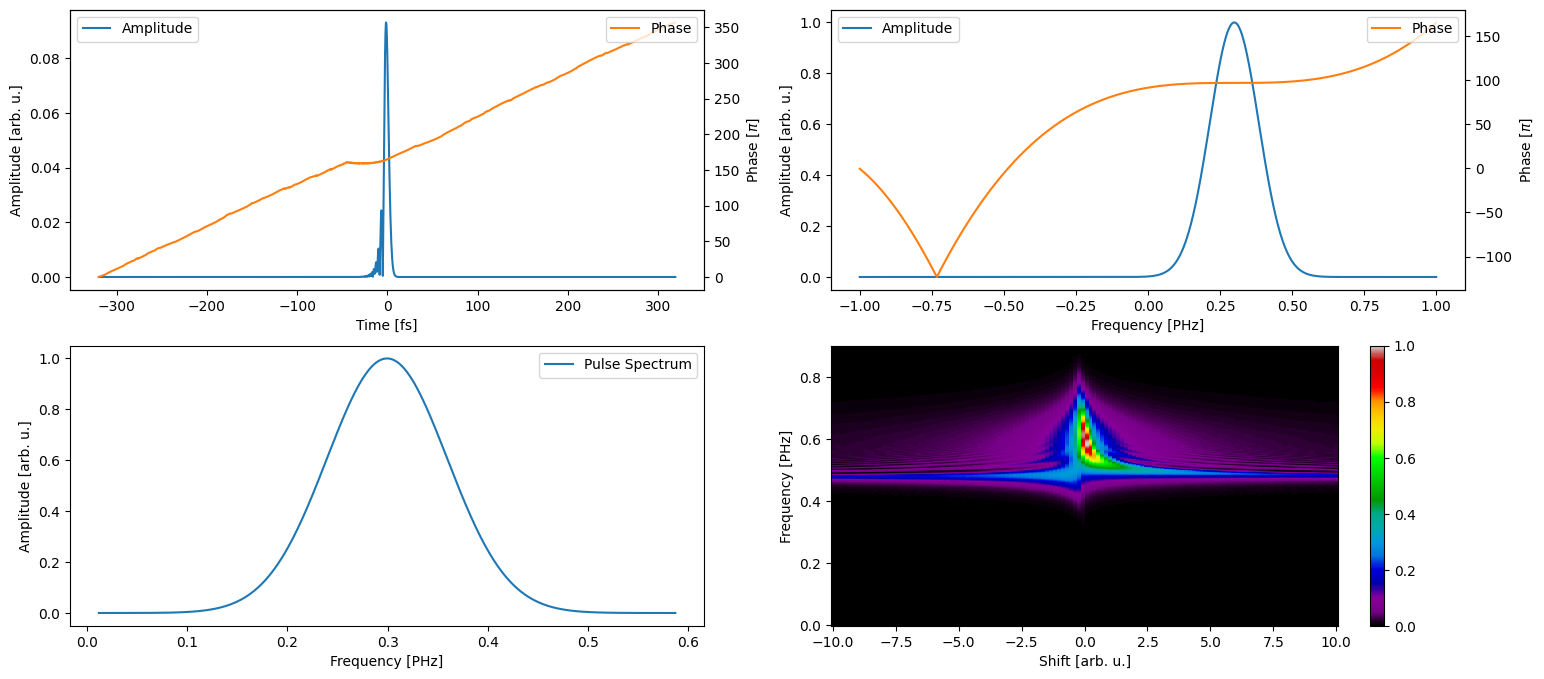

In [4]:
#from phase_matrix_funcs import parameters_material_scan as parameters, calculate_phase_matrix_miips as phase_matrix_func

from src.chirp_scan import phase_matrix_material as phase_matrix_func
from src.chirp_scan.phase_matrix_funcs import parameters_material_scan as parameters

pulse_maker = MakePulse(N=128*10, Delta_f=1)

central_f = np.array([0.3])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.array([0.5, 0, 0, 100]))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.2]))
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse((amp, phase))




z_arr=np.linspace(-10, 10, 128)
z_arr, frequency, trace, spectra = pulse_maker.generate_chirpscan(z_arr, time_inp, frequency_inp, pulse_t_inp, pulse_f_inp,
                                                              "shg", phase_matrix_func, parameters,
                                                              N=128*4, cut_off_val=1e-3, frequency_range=(0, 0.9))


#trace = apply_noise(trace, scale_val=0.01, additive_noise=True, multiplicative_noise=False)

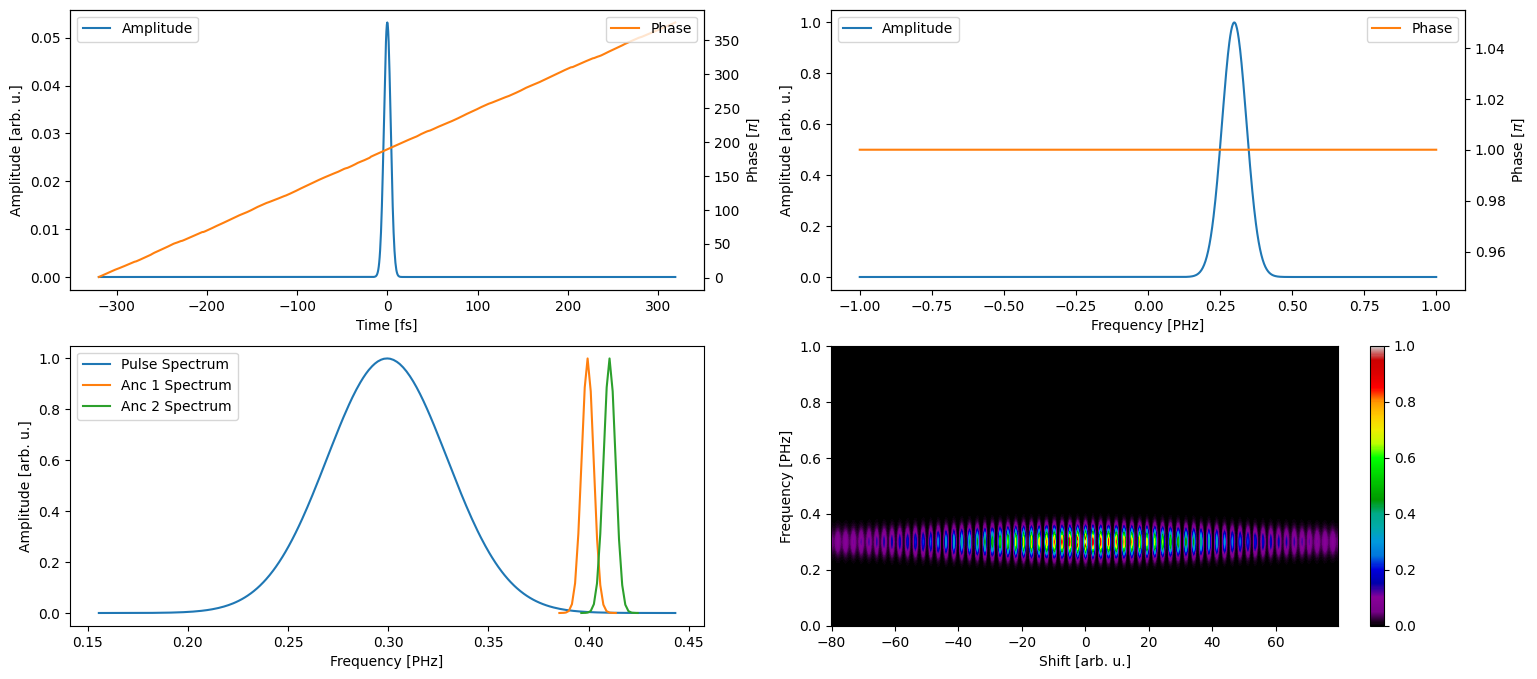

In [5]:
pulse_maker = MakePulse(N=128*10, Delta_f=1)

central_f = np.array([0.3])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.array([0.5, 0, 000]))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.1]))
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse((amp, phase))

input_pulses = pulse_maker.pulses



central_f = np.array([0.4])
phase = PolynomialPhase(central_frequency=central_f, coefficients = np.zeros(3))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.01]))
_, _, frequency_gate_1, pulse_f_gate_1 = pulse_maker.generate_pulse((amp, phase))


central_f = np.array([0.41])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.zeros(3))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.01]))
_, _, frequency_gate_2, pulse_f_gate_2 = pulse_maker.generate_pulse((amp, phase))




time, frequency, trace, spectra=pulse_maker.generate_2dsi(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, "pg", cross_correlation=True,
                                                          anc=((frequency_gate_1, pulse_f_gate_1),
                                                               (frequency_gate_2, pulse_f_gate_2)), 
                                                          N=256*4, scale_time_range=0.25, plot_stuff=True, cut_off_val=0.001, frequency_range=(0, 1))




In [6]:
from src.twodsi import DirectReconstruction

In [7]:
dr = DirectReconstruction(time, frequency, trace, "pg", True, 0.4, 0.405).use_measured_spectrum(spectra.pulse[0], spectra.pulse[1])
anc1 = dr.get_anc_pulse(frequency_gate_1, pulse_f_gate_1, anc_no=1)
anc2 = dr.get_anc_pulse(frequency_gate_2, pulse_f_gate_2, anc_no=2)

dr.use_windowing = False#"hamming"

population = dr.create_initial_population(1)
final_result = dr.run(population, no_iterations=1)

In [4]:
dr.plot_results(final_result, exact_pulse=input_pulses)

NameError: name 'dr' is not defined

In [5]:
from src.frog import Vanilla, LSGPA, GeneralizedProjection, TimeDomainPtychography, COPRA

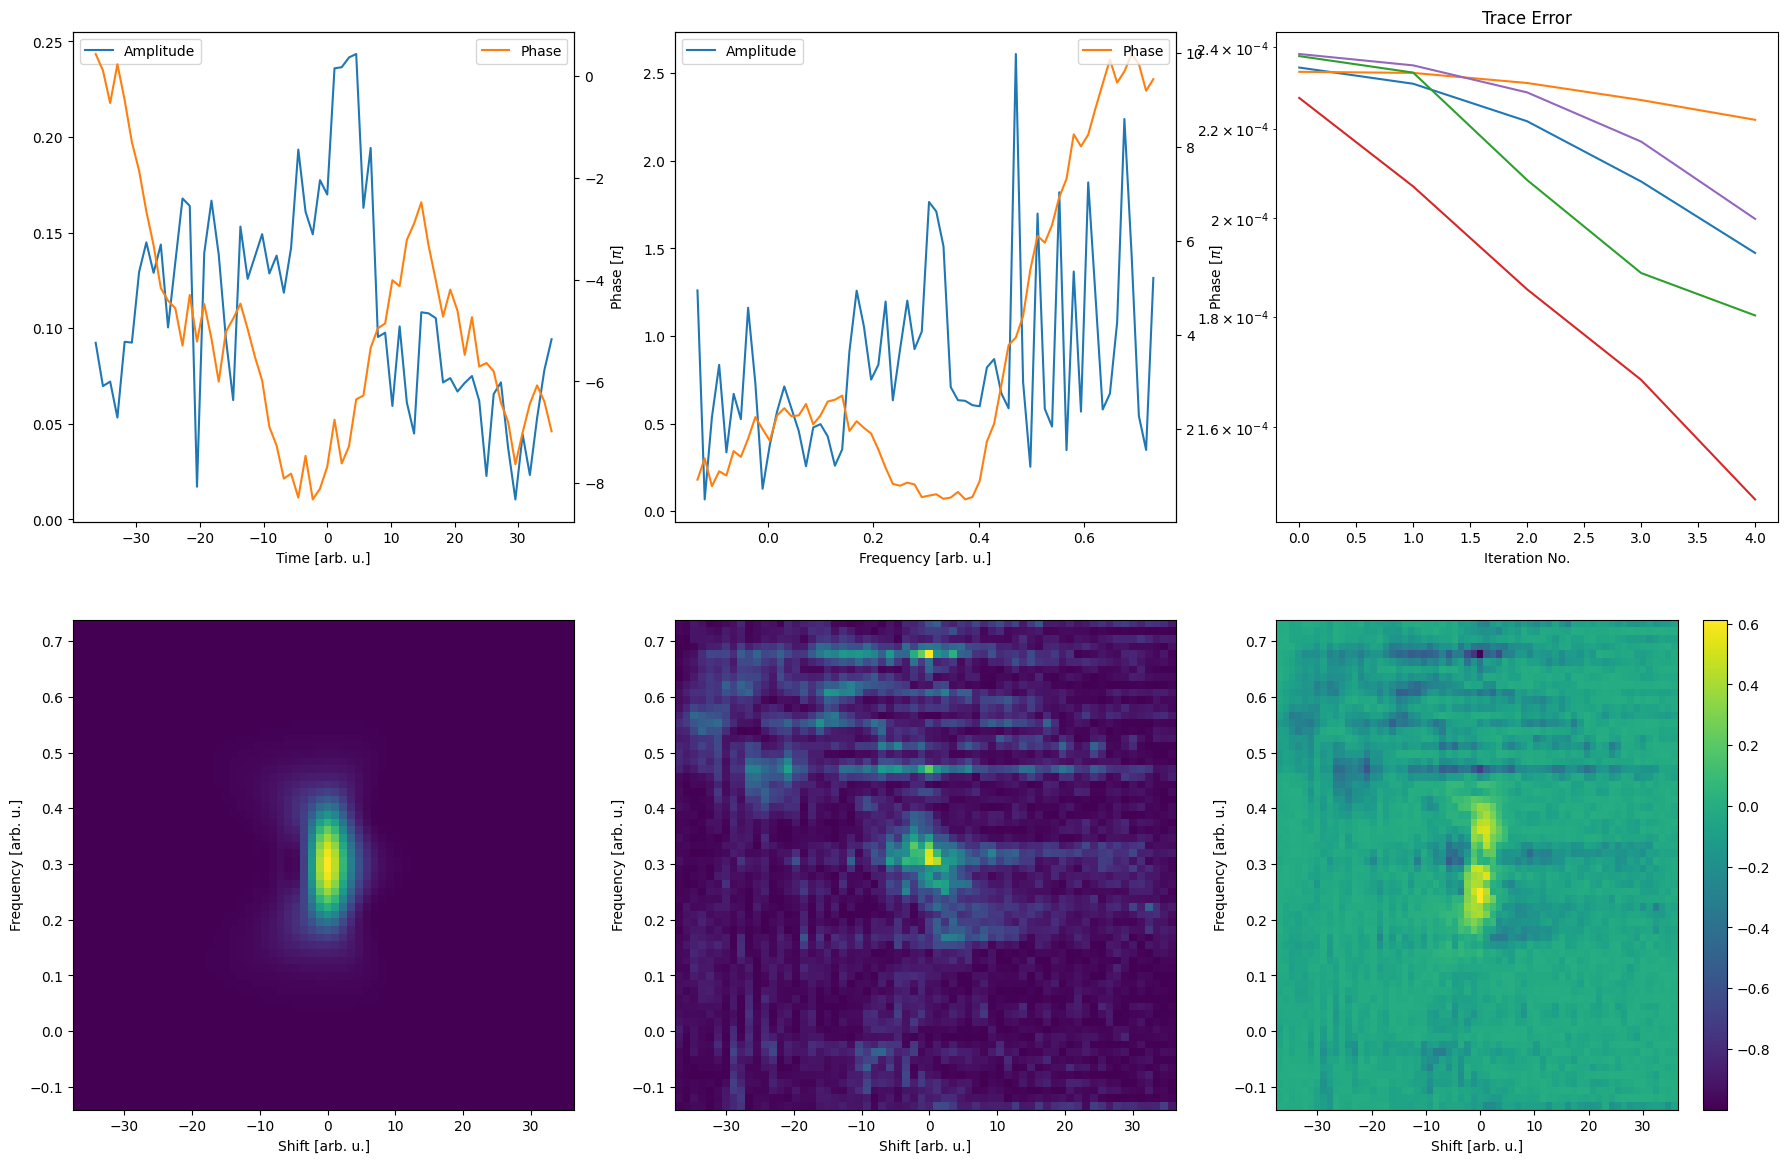

In [5]:
# vanilla = Vanilla(time, frequency, trace, "pg")
# population = vanilla.create_initial_population(population_size=3, guess_type="random")

# final_result = vanilla.run(population, 10)
# vanilla.plot_results(final_result)






# lsgpa = LSGPA(time, frequency, trace, "pg", cross_correlation=False)#.use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")
# population = lsgpa.create_initial_population(population_size=3, guess_type="random")

# final_result = lsgpa.run(population, 10)
# lsgpa.plot_results(final_result)






gp = GeneralizedProjection(time, frequency, trace, "pg", cross_correlation=False)
population = gp.create_initial_population(population_size=5, guess_type="random")

# gp.global_newton = "full"
# gp.conjugate_gradients = False
# gp.linalg_solver = "lineax"

gp.global_gamma=0.5

gp.no_steps_descent = 15
# gp.max_steps_linesearch = 15
# gp.use_linesearch = "zoom"
# gp.global_gamma = 1.0
# gp.delta_gamma = 2.0
# gp.c1 = 1e-4
# gp.c2 = 0.5

# gp.lbfgs_memory = 3

# gp.use_copra_style_step_scaling = False


final_result = gp.run(population, 5)
gp.plot_results(final_result)






# tdp = TimeDomainPtychography(time, frequency, trace, "pg", "rPIE", cross_correlation=False)
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# # tdp.alpha = 0.1
# # tdp.local_gamma = 0.1
# # tdp.global_gamma = 0.1

# # tdp.lbfgs_memory = 15
# # tdp.conjugate_gradients = False#"fletcher_reeves"

# tdp.local_newton = "diagonal" #"lbfgs"
# # tdp.use_linesearch = "backtracking" #"wolfe"
# # #tdp.lambda_lm = 1e-2

# tdp.r_local_method = "iteration"
# tdp.r_gradient = "amplitude"
# tdp.r_newton = True
# tdp.r_no_iterations = 2

# final_result = tdp.run(population, 5, 5)
# tdp.plot_results(final_result)





# copra = COPRA(time, frequency, trace, "pg", ifrog=False)#, cross_correlation="doubleblind")
# population = copra.create_initial_population(population_size=5, guess_type="random")

# # copra.use_linesearch = False #"wolfe"

# # copra.local_gamma=1
# # copra.global_gamma=0.5
# # copra.local_adaptive_scaling = "original"
# # copra.global_adaptive_scaling = "original"
# # copra.xi=1e-12

# # copra.local_hessian=False
# # copra.global_hessian=False#"full"

# final_result = copra.run(population, 10, 10)
# copra.plot_results(final_result)



In [20]:
r = gp.descent_state

In [34]:
y=1
jax.tree.map(lambda x: x+y, r)

[[population, [[pulse, (5, 64), dtype(complex64)], [gate, (), NoneType]]], [cg, [[pulse, [[CG_direction_prev, (5, 64), dtype(complex64)], [descent_direction_prev, (5, 64), dtype(complex64)]]], [gate, (), NoneType]]], [newton, [[pulse, [[newton_direction_prev, (5, 64), dtype(complex64)]]], [gate, (), NoneType]]], [lbfgs, [[pulse, [[grad_prev, (5, 10, 64), dtype(complex64)], [newton_direction_prev, (5, 10, 64), dtype(complex64)], [step_size_prev, (5, 10, 1), dtype(float32)]]], [gate, (), NoneType]]]]

In [4]:
from src.chirp_scan import Basic, GeneralizedProjection, TimeDomainPtychography, COPRA

In [6]:
# basic = Basic(z_arr, frequency, trace, "shg", phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
# population = basic.create_initial_population(population_size=3, guess_type="random")

# final_result = basic.run(population, 10)
# basic.plot_results(final_result)





gp = GeneralizedProjection(z_arr, frequency, trace, "shg", phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
population = gp.create_initial_population(population_size=3, guess_type="random")

gp.global_newton="diagonal"
# gp.no_steps_descent=50
# gp.gamma=1

final_result = gp.run(population, 10)
gp.plot_results(final_result)




# tdp = TimeDomainPtychography(z_arr, frequency, trace, "shg", pie_method="rPIE", 
#                              phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# # tdp.alpha=0.1
# # tdp.local_gamma=0.001
# # tdp.global_gamma=0.001

# # tdp.use_linesearch=False
# # tdp.global_hessian=False #"diagonal"

# final_result = tdp.run(population, 10, 10)
# tdp.plot_results(final_result)






# copra = COPRA(z_arr, frequency, trace, "shg", phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
# population = copra.create_initial_population(population_size=3, guess_type="random")

# # copra.local_gamma = 1
# # copra.global_gamma = 0.25

# # copra.local_hessian = False
# # copra.global_hessian = False

# # copra.local_adaptive_scaling = False
# # copra.global_adaptive_scaling = False

# # copra.xi=1e-6

# final_result = copra.run(population, 10, 10)
# copra.plot_results(final_result)

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:297: RuntimeWarning: invalid value encountered in divide
  g = lambda c1, c2, w: c1 * (w ** 2) / (w ** 2 - c2 ** 2)
/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


TypeError: calc_Z_error_pseudo_hessian_one_m() got multiple values for argument 'time'

In [9]:
Basic.__mro__

(src.chirp_scan.classic_algorithms_chirpscan.Basic,
 src.core.base_classes_algorithms.ClassicAlgorithmsBASE,
 src.core.base_classes_algorithms.AlgorithmsBASE,
 src.core.base_classes_methods.RetrievePulsesCHIRPSCAN,
 src.core.base_classes_methods.RetrievePulses,
 object)

In [4]:
from src.frog.general_algorithms_frog_real_fields import DifferentialEvolution, Evosax, LSF, AutoDiff

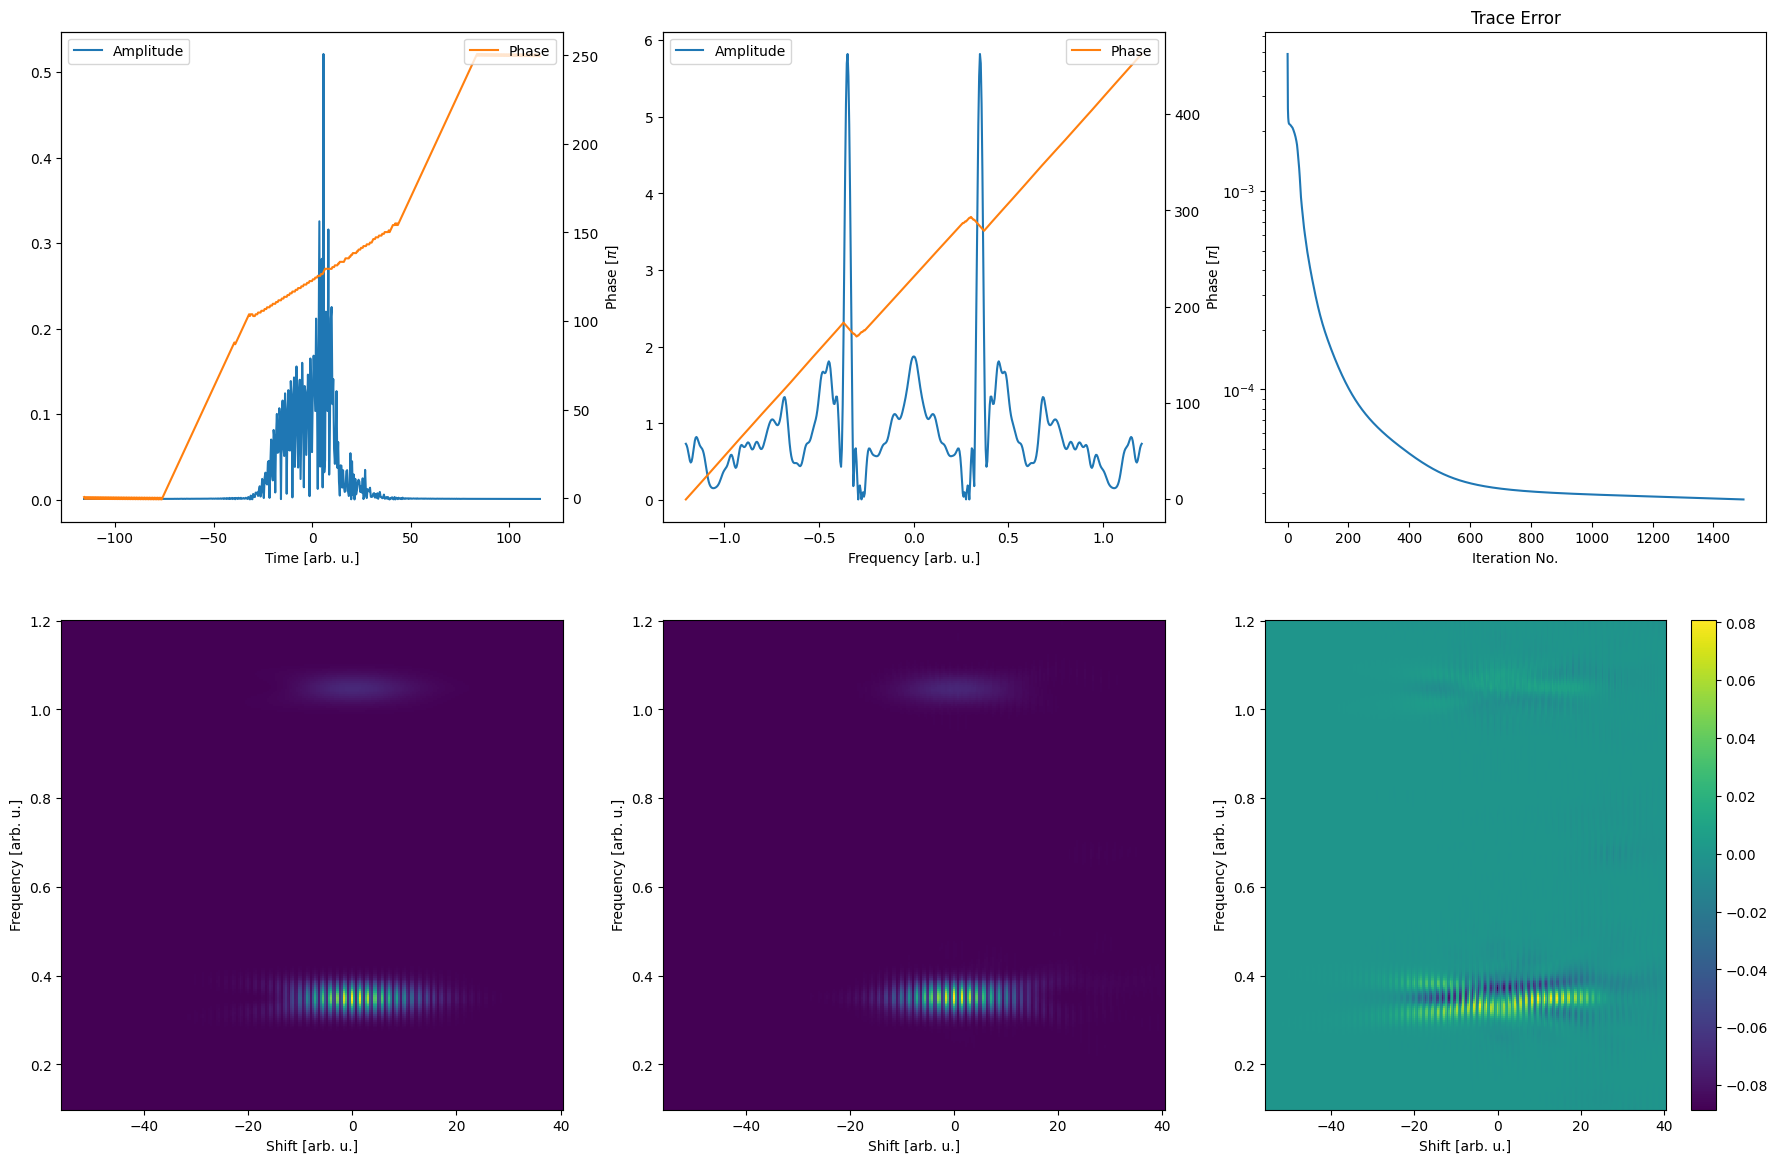

In [18]:
# de = DifferentialEvolution(time, frequency, trace, "thg", cross_correlation=False)#.use_measured_spectrum()
# #spectral_amplitude = de.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# #spectral_amplitude = de.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = de.create_initial_population(population_size=100, phase_type="bsplines_5", amp_type="bsplines_5", no_funcs_phase=25, no_funcs_amp=25)

# de.strategy="best1_bin"

# final_result = de.run(population, 20)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(time, frequency, trace, "pg", cross_correlation="doubleblind")#.use_measured_spectrum()
# # spectral_amplitude = evo.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# # spectral_amplitude = evo.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = evo.create_initial_population(population_size=10)

# evo.solver = CMA_ES

# final_result = evo.run(population, 10)
# evo.plot_results(final_result)




# lsf = LSF(time, frequency, trace, "pg", cross_correlation=False)#.use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")

# population = lsf.create_initial_population(population_size=3, amp_type="discrete", phase_type="discrete")

# lsf.number_of_bisection_iterations=12
# lsf.random_direction_mode="random"
# lsf.no_points_for_continuous=5

# final_result = lsf.run(population, 10)
# lsf.plot_results(final_result)





ad = AutoDiff(time, frequency, trace, "thg", cross_correlation=False)#"doubleblind")#.use_measured_spectrum()

# spectral_amplitude = ad.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = ad.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

population = ad.create_initial_population(population_size=1, amp_type="bsplines_5", phase_type="bsplines_5", no_funcs_amp=50, no_funcs_phase=50)

# ad.alternating_optimization = True
# ad.solver = optax.adam(learning_rate=1e-1)

import optimistix
import optax
ad.solver = optax.adam(learning_rate=0.1)
population = pop_final
final_result = ad.run(population, 1500)
ad.plot_results(final_result)

In [17]:
pop_final = ad.descent_state.population

In [10]:
x=jnp.linspace(-10,10,1000)
y=jnp.fft.fftshift(jnp.fft.fft(jnp.cos(x)))

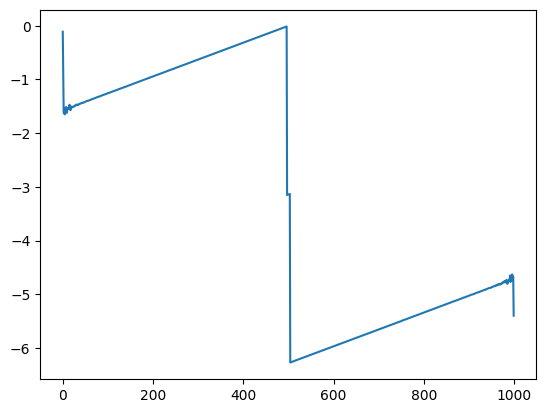

In [14]:
#plt.plot(jnp.abs(y))
plt.plot(jnp.unwrap(jnp.angle(y)))

In [14]:
ad.time.shape, ad.frequency.shape[0]*2-1, ad.sk.shape, ad.rn.shape

((559,), 559, (559,), (559,))

In [6]:
560/2+560

840.0

In [52]:
state = equinox.combine(ad.descent_state, ad.static)

In [53]:
res = ad.optimistix_step(y=state.individual, state=state.optimistix_state)

In [6]:
import equinox

In [44]:
leaf_c, struct = jax.tree.flatten(equinox.combine(ad.static, ad.descent_state), is_leaf=lambda x: x is None)

In [54]:
leaf_a, struct_a = jax.tree.flatten(res[0], is_leaf=lambda x: x is None)
leaf_b, struct_b = jax.tree.flatten(res[1], is_leaf=lambda x: x is None)

In [49]:
res[0], res[1]

(FunctionLinearOperator(
   fn=_ClosureConvert(
     jaxpr=None,
     consts=[
       i32[8,1],
       f32[4,9],
       f32[],
       c64[],
       c64[64],
       c64[64],
       c64[64],
       c64[64],
       i32[8,1],
       f32[4,9],
       c64[],
       c64[64],
       c64[64],
       c64[],
       c64[128],
       c64[128],
       c64[64,128],
       c64[1,128],
       c64[1,128],
       c64[64,64],
       f32[64,64],
       c64[64,64],
       c64[1,64],
       c64[1,64],
       c64[1,64],
       c64[64,64],
       f32[64,64],
       bool[64,64],
       f32[64,64],
       f32[],
       f32[],
       f32[64,64],
       f32[],
       bool[64,64],
       f32[64,64]
     ],
     in_dynamic_struct=(
       [
         ShapeDtypeStruct(shape=(64,), dtype=float32),
         ShapeDtypeStruct(shape=(11,), dtype=float32),
         ShapeDtypeStruct(shape=(64,), dtype=float32),
         ShapeDtypeStruct(shape=(11,), dtype=float32)
       ],
       PyTreeDef(((CustomNode(MyNamespace[['pulse',

In [35]:
i = 35

leaf_a[i], leaf_b[i]

(Array([[1.41505996e-04, 1.50614098e-04, 1.76376561e-04, ...,
         1.42327146e-04, 1.15448973e-04, 1.09234912e-04],
        [1.74340967e-05, 6.48393052e-06, 3.06923757e-05, ...,
         1.36665449e-05, 1.40990915e-05, 1.09705470e-05],
        [4.86133868e-05, 4.86017343e-05, 4.04394559e-05, ...,
         2.11071419e-05, 3.90417226e-05, 3.31504853e-05],
        ...,
        [1.60206377e-03, 1.95040030e-03, 2.03472376e-03, ...,
         1.40576693e-03, 1.66364794e-03, 1.73890637e-03],
        [5.38954104e-04, 7.96051987e-04, 7.43822660e-04, ...,
         5.42750291e-04, 3.54150980e-04, 6.70111855e-04],
        [1.86061559e-04, 5.64775000e-05, 3.19470419e-04, ...,
         1.36344033e-05, 7.29673411e-05, 1.12982743e-05]], dtype=float32),
 None)

In [38]:
struct_a, struct_b

(PyTreeDef(CustomNode(FunctionLinearOperator[('fn',), (('input_structure', ([ShapeDtypeStruct(shape=(64,), dtype=float32), ShapeDtypeStruct(shape=(11,), dtype=float32), ShapeDtypeStruct(shape=(64,), dtype=float32), ShapeDtypeStruct(shape=(11,), dtype=float32)], PyTreeDef(CustomNode(MyNamespace[['pulse', 'gate']], [CustomNode(MyNamespace[['amp', 'phase']], [*, CustomNode(MyNamespace[['c']], [*])]), CustomNode(MyNamespace[['amp', 'phase']], [*, CustomNode(MyNamespace[['c']], [*])])])))), ('tags', frozenset()))], [CustomNode(_ClosureConvert[('jaxpr', 'consts'), (('in_dynamic_struct', ([ShapeDtypeStruct(shape=(64,), dtype=float32), ShapeDtypeStruct(shape=(11,), dtype=float32), ShapeDtypeStruct(shape=(64,), dtype=float32), ShapeDtypeStruct(shape=(11,), dtype=float32)], PyTreeDef(((CustomNode(MyNamespace[['pulse', 'gate']], [CustomNode(MyNamespace[['amp', 'phase']], [*, CustomNode(MyNamespace[['c']], [*])]), CustomNode(MyNamespace[['amp', 'phase']], [*, CustomNode(MyNamespace[['c']], [*])])]

In [ ]:
PyTreeDef(CustomNode(FunctionLinearOperator[('fn',), (('input_structure', ([ShapeDtypeStruct(shape=(64,), dtype=float32), ShapeDtypeStruct(shape=(11,), dtype=float32), ShapeDtypeStruct(shape=(64,), dtype=float32), ShapeDtypeStruct(shape=(11,), dtype=float32)], PyTreeDef(CustomNode(MyNamespace[['pulse', 'gate']], [CustomNode(MyNamespace[['amp', 'phase']], [*, CustomNode(MyNamespace[['c']], [*])]), CustomNode(MyNamespace[['amp', 'phase']], [*, CustomNode(MyNamespace[['c']], [*])])])))), ('tags', frozenset()))], [CustomNode(_ClosureConvert[('jaxpr', 'consts'), (('in_dynamic_struct', ([ShapeDtypeStruct(shape=(64,), dtype=float32), ShapeDtypeStruct(shape=(11,), dtype=float32), ShapeDtypeStruct(shape=(64,), dtype=float32), ShapeDtypeStruct(shape=(11,), dtype=float32)], PyTreeDef(((CustomNode(MyNamespace[['pulse', 'gate']], [CustomNode(MyNamespace[['amp', 'phase']], [*, CustomNode(MyNamespace[['c']], [*])]), CustomNode(MyNamespace[['amp', 'phase']], [*, CustomNode(MyNamespace[['c']], [*])])]),), {})))), ('out_dynamic_struct', ([ShapeDtypeStruct(shape=(), dtype=float32)], PyTreeDef(*))), ('in_static', ([], PyTreeDef(((CustomNode(MyNamespace[['pulse', 'gate']], [CustomNode(MyNamespace[['amp', 'phase']], [None, CustomNode(MyNamespace[['c']], [None])]), CustomNode(MyNamespace[['amp', 'phase']], [None, CustomNode(MyNamespace[['c']], [None])])]),), {})))), ('out_static', ([], PyTreeDef(None))))], [*, [*, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *]])])),
 

In [49]:
dir(ad.static.optimistix_state), dir(equinox.combine(ad.static, ad.descent_state).optimistix_state)

(51, 51)

In [26]:
dir(ad.descent_state), dir(ad.static)

(['__add__',
  '__class__',
  '__delattr__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__getstate__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__le__',
  '__lt__',
  '__module__',
  '__mul__',
  '__ne__',
  '__new__',
  '__radd__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__rmul__',
  '__setattr__',
  '__sizeof__',
  '__str__',
  '__sub__',
  '__subclasshook__',
  '__weakref__',
  'expand',
  'individual',
  'optimistix_state',
  'population'],
 ['__add__',
  '__class__',
  '__delattr__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__getstate__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__le__',
  '__lt__',
  '__module__',
  '__mul__',
  '__ne__',
  '__new__',
  '__radd__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__rmul__',
  '__setattr__',
  '__sizeof__',
  '__str__',
  '__sub__',
  '__subcl

In [29]:
from src.chirp_scan import DifferentialEvolution, Evosax, LSF, AutoDiff

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:297: RuntimeWarning: invalid value encountered in divide
  g = lambda c1, c2, w: c1 * (w ** 2) / (w ** 2 - c2 ** 2)
/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


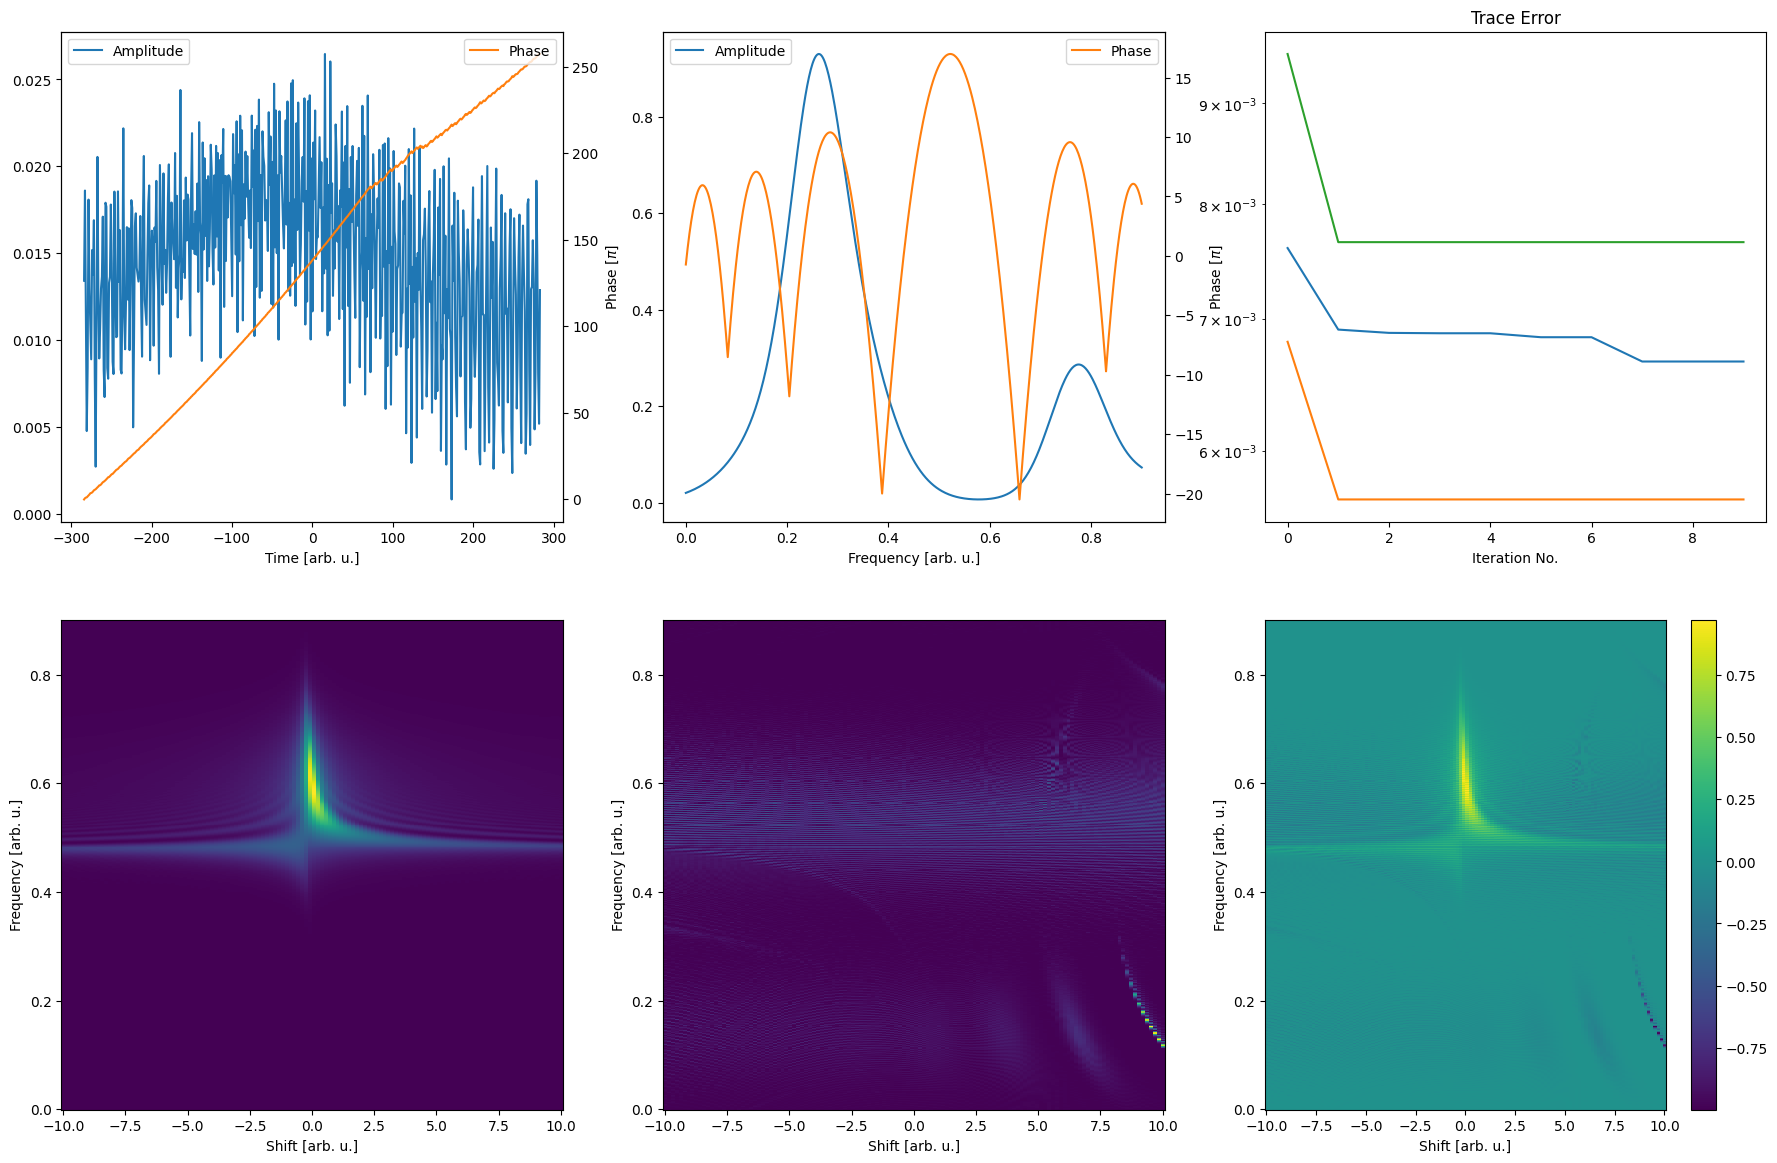

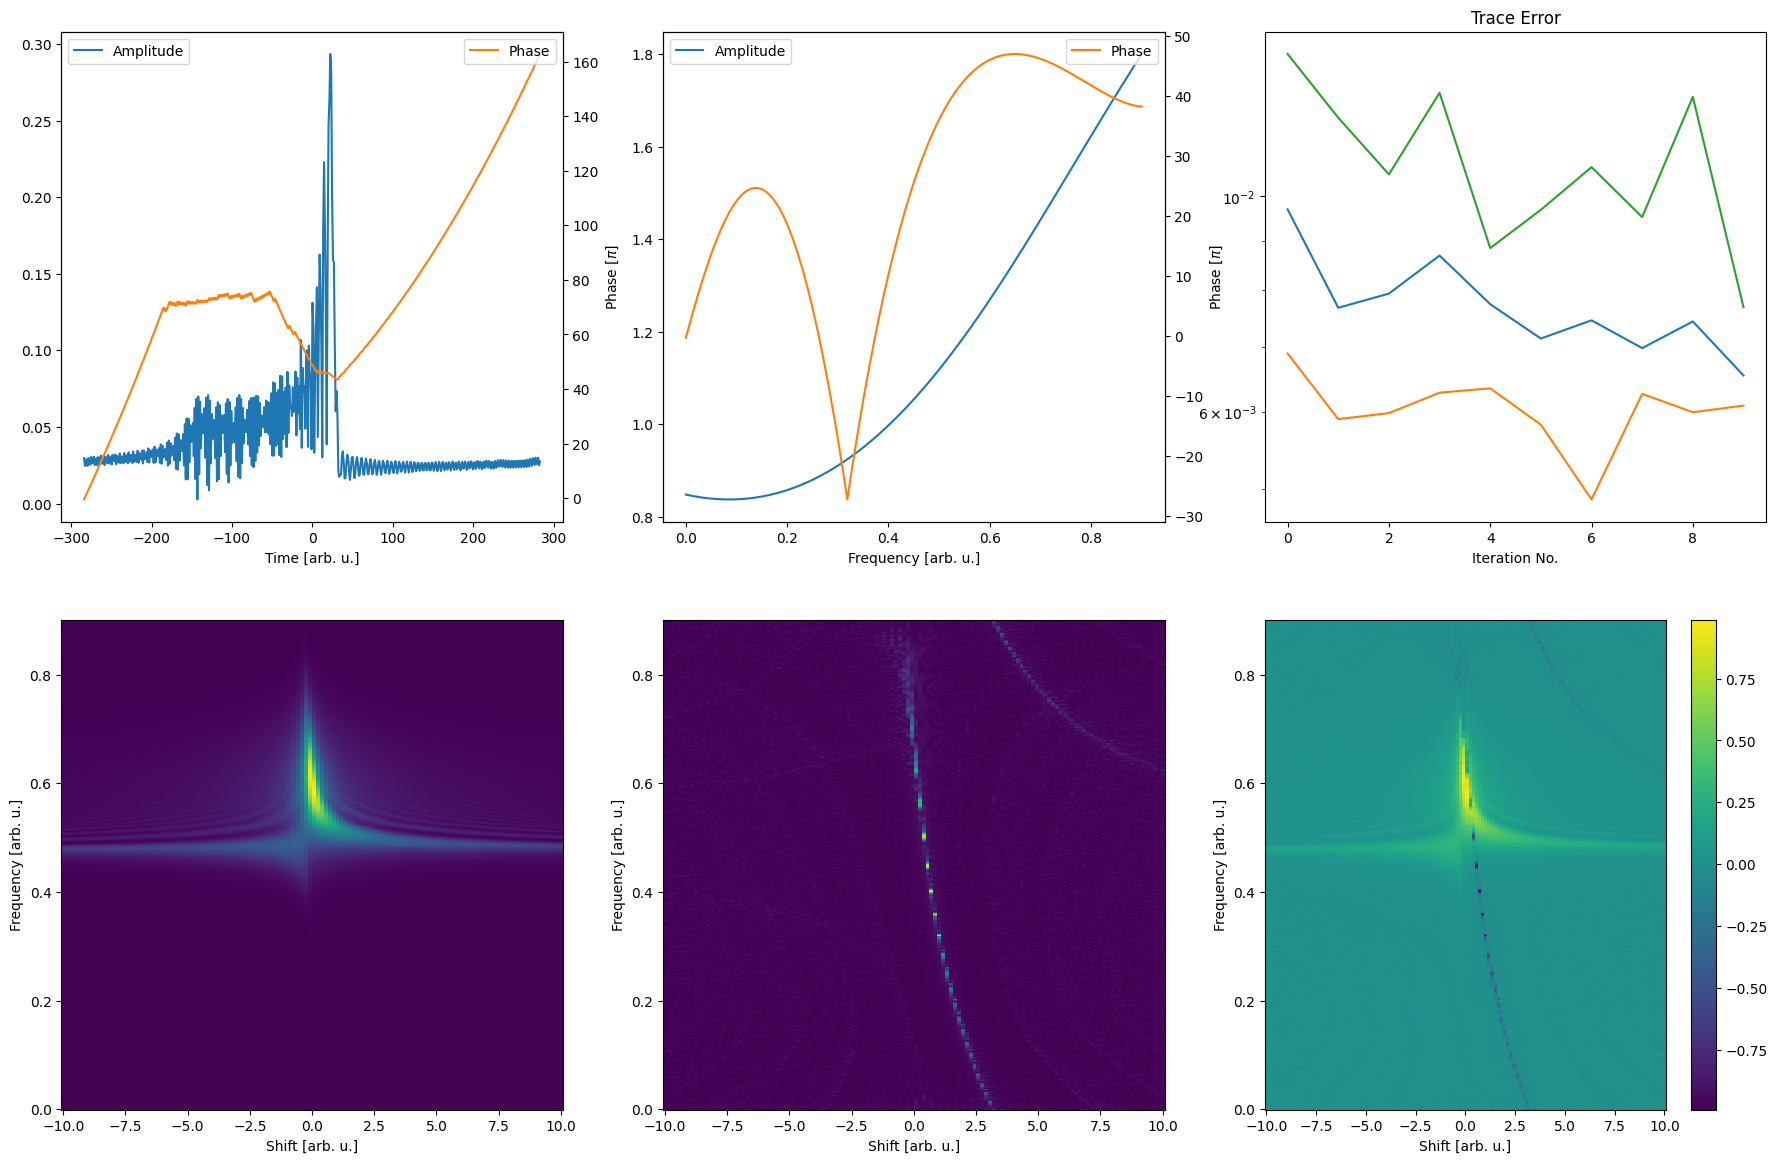

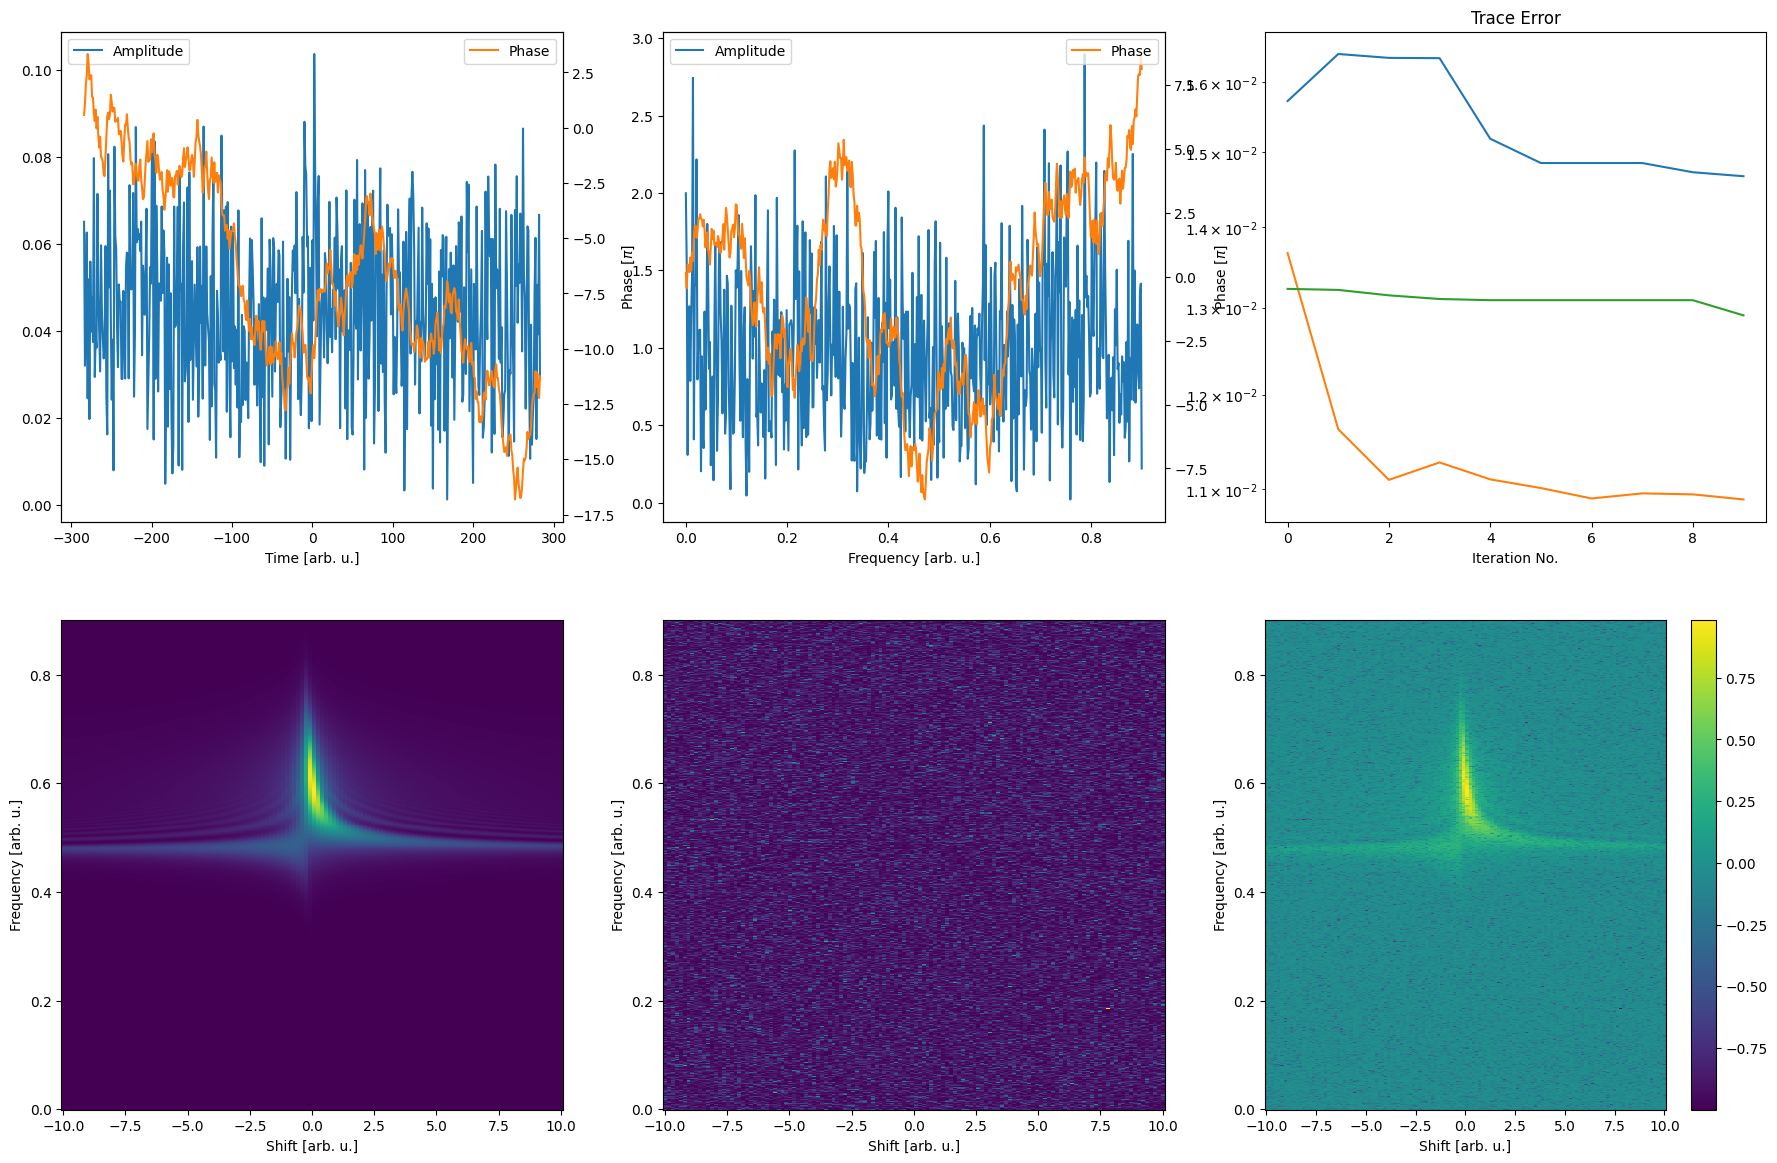

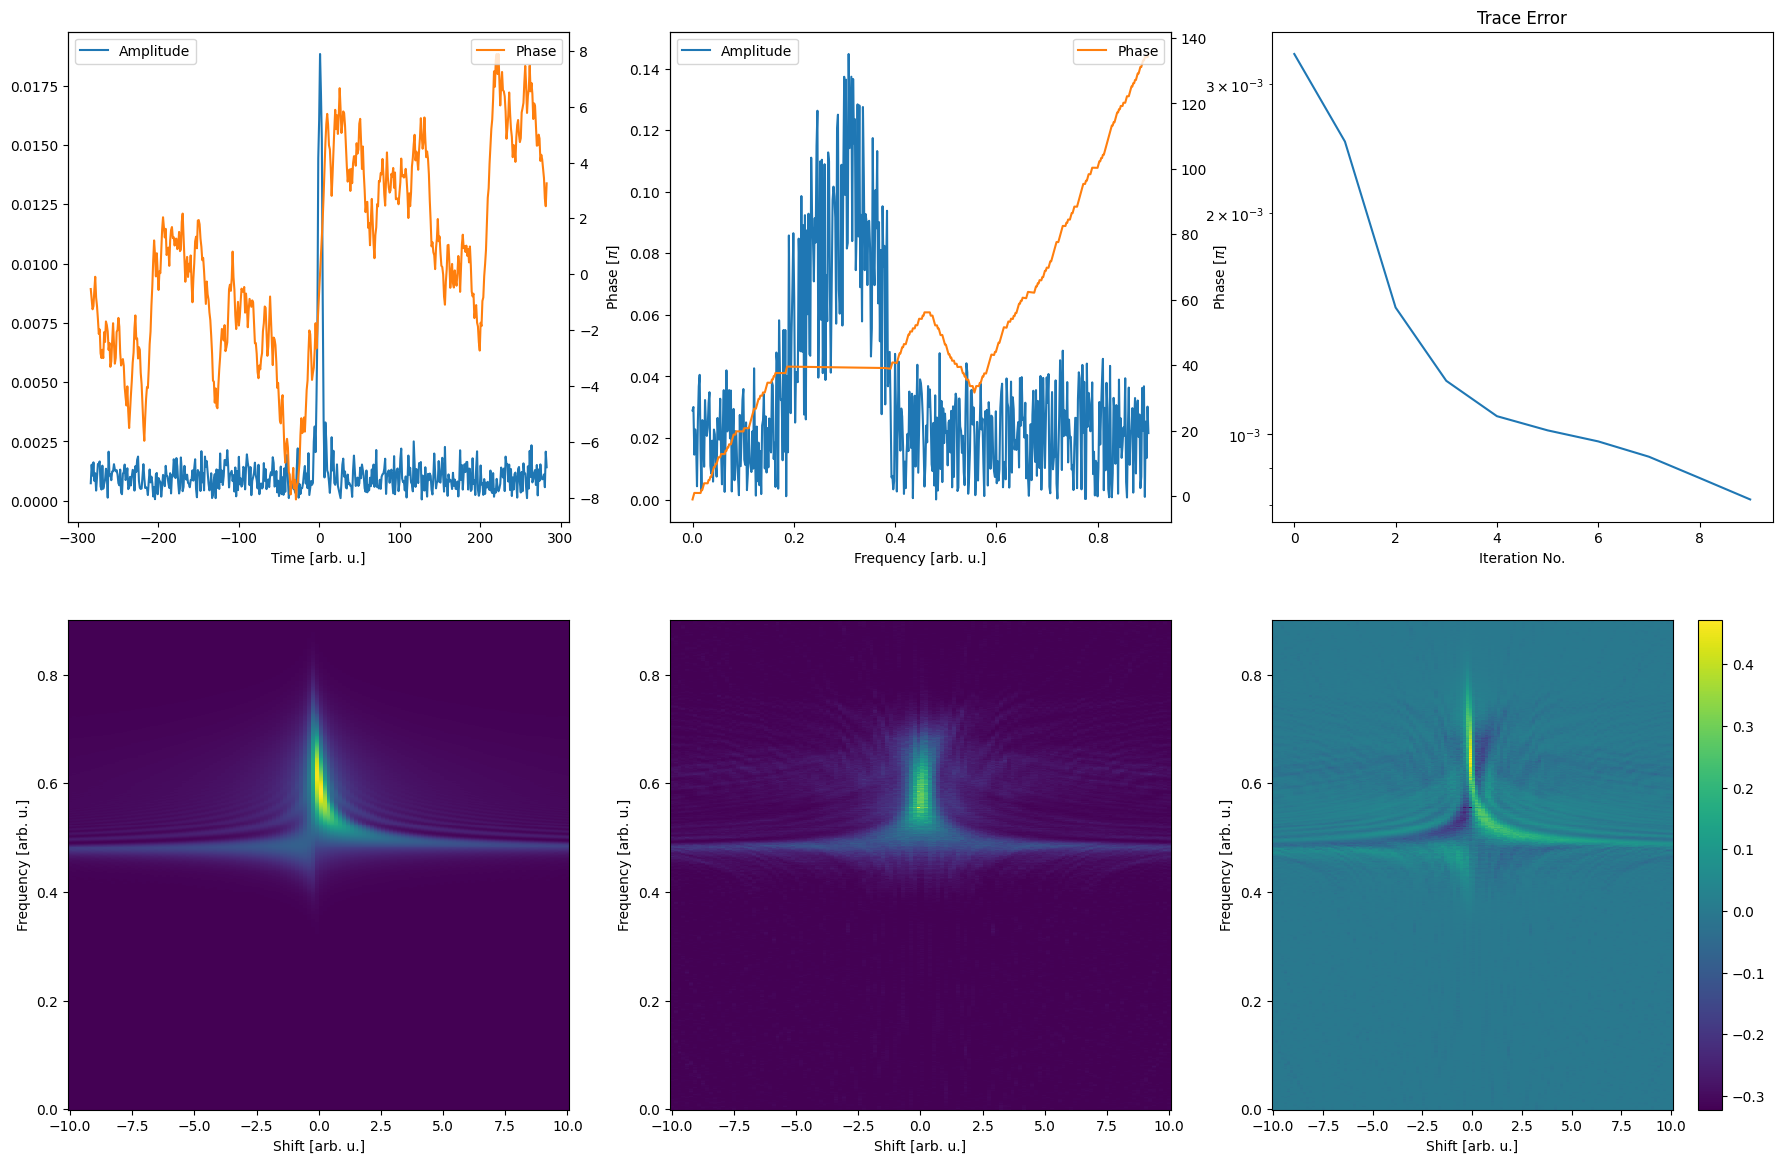

In [31]:
de = DifferentialEvolution(z_arr, frequency, trace, "shg", phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
population = de.create_initial_population(population_size=10)

final_result = de.run(population, 10)
de.plot_results(final_result)




from evosax.algorithms import CMA_ES
evo = Evosax(z_arr, frequency, trace, "shg", phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
evo.solver = CMA_ES
population = evo.create_initial_population(population_size=10)

final_result = evo.run(population, 10)
evo.plot_results(final_result)




lsf = LSF(z_arr, frequency, trace, "shg", phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
population = lsf.create_initial_population(population_size=3, amp_type="random", phase_type="random")

lsf.number_of_bisection_iterations=8
lsf.random_direction_mode="random"
lsf.no_points_for_continuous=15

final_result = lsf.run(population, 10)
lsf.plot_results(final_result)





ad = AutoDiff(z_arr, frequency, trace, "shg", phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

#ad.solver=optax.adam(learning_rate=1e-1)

final_result = ad.run(population, 10)
ad.plot_results(final_result)